In [312]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

In [313]:
data = pd.read_csv('NY-House-Dataset.csv')

In [314]:
data['PRICE'] = data['PRICE'].astype(str)

In [315]:
columns_to_drop = [
    'BROKERTITLE', 'MAIN_ADDRESS', 'ADMINISTRATIVE_AREA_LEVEL_2', 
    'LONG_NAME', 'FORMATTED_ADDRESS', 'LOCALITY', 'SUBLOCALITY', 
    'STREET_NAME', 'STATE'
]
data_cleaned = data.drop(columns=columns_to_drop)

In [316]:
# Drop rows with specified "TYPE" values
types_to_drop = ['Pending', 'Contingent', 'Land for sale', 'For sale', 
                 'Foreclosure', 'Condop for sale', 'Coming Soon', 
                 'Mobile house for sale']
data_cleaned = data_cleaned[~data_cleaned['TYPE'].isin(types_to_drop)]

In [317]:
# Convert numerical columns to the correct data types
data_cleaned['PRICE'] = pd.to_numeric(data_cleaned['PRICE'].str.replace(',', ''), errors='coerce')
data_cleaned['BEDS'] = pd.to_numeric(data_cleaned['BEDS'], errors='coerce')
data_cleaned['BATH'] = pd.to_numeric(data_cleaned['BATH'], errors='coerce')
data_cleaned['PROPERTYSQFT'] = pd.to_numeric(data_cleaned['PROPERTYSQFT'], errors='coerce')

In [318]:
# Load the shapefile
shapefile_path = 'cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp'
zip_shapefile  = gpd.read_file(shapefile_path)

In [319]:
# Create a GeoDataFrame from the cleaned dataset
geometry = [Point(xy) for xy in zip(data_cleaned['LONGITUDE'], data_cleaned['LATITUDE'])]
geo_data_cleaned = gpd.GeoDataFrame(data_cleaned, geometry=geometry)

# Ensure the GeoDataFrame and shapefile use the same coordinate reference system (CRS)
geo_data_cleaned = geo_data_cleaned.set_crs(zip_shapefile.crs, allow_override=True)

# Perform the spatial join to map latitude and longitude to ZIP codes
joined_data = gpd.sjoin(geo_data_cleaned, zip_shapefile, how='left', op='within')

# Extract the relevant columns (including the ZIP code from the shapefile)
joined_data = joined_data[['PRICE', 'BEDS', 'TYPE', 'BATH', 'PROPERTYSQFT', 'LATITUDE', 'LONGITUDE', 'geometry', 'ZCTA5CE10']]

# Rename the ZIP code column for clarity
joined_data = joined_data.rename(columns={'ZCTA5CE10': 'ZIPCODE'})

C:\Users\simon\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [320]:
joined_data

,PRICE,BEDS,TYPE,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE,geometry,ZIPCODE
0,315000,2,Condo for sale,2.000000,1400.000000,40.761255,-73.974483,POINT (-73.97448 40.76125),10022
1,195000000,7,Condo for sale,10.000000,17545.000000,40.766393,-73.980991,POINT (-73.98099 40.76639),10019
2,260000,4,House for sale,2.000000,2015.000000,40.541805,-74.196109,POINT (-74.19611 40.54181),10312
3,69000,3,Condo for sale,1.000000,445.000000,40.761398,-73.974613,POINT (-73.97461 40.76140),10022
4,55000000,7,Townhouse for sale,2.373861,14175.000000,40.767224,-73.969856,POINT (-73.96986 40.76722),10065
...,...,...,...,...,...,...,...,...,...
4796,599000,1,Co-op for sale,1.000000,2184.207862,40.774350,-73.955879,POINT (-73.95588 40.77435),10075
4797,245000,1,Co-op for sale,1.000000,2184.207862,40.732538,-73.860152,POINT (-73.86015 40.73254),11374
4798,1275000,1,Co-op for sale,1.000000,2184.207862,40.745882,-74.003398,POINT (-74.00340 40.74588),10011
4799,598125,2,Condo for sale,1.000000,655.000000,40.742770,-73.872752,POINT (-73.87275 40.74277),11373


In [321]:
# Create a dictionary for ZIP code to borough and neighborhood mapping
zipcode_to_borough_neighborhood = {
    '10463': ('Bronx', 'Kingsbridge - Riverdale'), '10471': ('Bronx', 'Kingsbridge - Riverdale'),
    '10466': ('Bronx', 'Northeast Bronx'), '10469': ('Bronx', 'Northeast Bronx'), '10470': ('Bronx', 'Northeast Bronx'), '10475': ('Bronx', 'Northeast Bronx'),
    '10458': ('Bronx', 'Fordham - Bronx Park'), '10467': ('Bronx', 'Fordham - Bronx Park'), '10468': ('Bronx', 'Fordham - Bronx Park'),
    '10461': ('Bronx', 'Pelham - Throgs Neck'), '10462': ('Bronx', 'Pelham - Throgs Neck'), '10464': ('Bronx', 'Pelham - Throgs Neck'), 
    '10465': ('Bronx', 'Pelham - Throgs Neck'), '10472': ('Bronx', 'Pelham - Throgs Neck'), '10473': ('Bronx', 'Pelham - Throgs Neck'),
    '10453': ('Bronx', 'Crotona - Tremont'), '10457': ('Bronx', 'Crotona - Tremont'), '10460': ('Bronx', 'Crotona - Tremont'),
    '10451': ('Bronx', 'High Bridge - Morrisania'), '10452': ('Bronx', 'High Bridge - Morrisania'), '10456': ('Bronx', 'High Bridge - Morrisania'),
    '10454': ('Bronx', 'Hunts Point - Mott Haven'), '10455': ('Bronx', 'Hunts Point - Mott Haven'), '10459': ('Bronx', 'Hunts Point - Mott Haven'), '10474': ('Bronx', 'Hunts Point - Mott Haven'),
    '11211': ('Brooklyn', 'Greenpoint'), '11222': ('Brooklyn', 'Greenpoint'),
    '11201': ('Brooklyn', 'Downtown - Heights - Park Slope'), '11205': ('Brooklyn', 'Downtown - Heights - Park Slope'), '11215': ('Brooklyn', 'Downtown - Heights - Park Slope'), 
    '11217': ('Brooklyn', 'Downtown - Heights - Park Slope'), '11231': ('Brooklyn', 'Downtown - Heights - Park Slope'),
    '11213': ('Brooklyn', 'Bedford Stuyvesant - Crown Heights'), '11212': ('Brooklyn', 'Bedford Stuyvesant - Crown Heights'), 
    '11216': ('Brooklyn', 'Bedford Stuyvesant - Crown Heights'), '11233': ('Brooklyn', 'Bedford Stuyvesant - Crown Heights'), '11238': ('Brooklyn', 'Bedford Stuyvesant - Crown Heights'),
    '11207': ('Brooklyn', 'East New York'), '11208': ('Brooklyn', 'East New York'),
    '11220': ('Brooklyn', 'Sunset Park'), '11232': ('Brooklyn', 'Sunset Park'),
    '11204': ('Brooklyn', 'Borough Park'), '11218': ('Brooklyn', 'Borough Park'), '11219': ('Brooklyn', 'Borough Park'), '11230': ('Brooklyn', 'Borough Park'),
    '11203': ('Brooklyn', 'East Flatbush - Flatbush'), '11210': ('Brooklyn', 'East Flatbush - Flatbush'), '11225': ('Brooklyn', 'East Flatbush - Flatbush'), '11226': ('Brooklyn', 'East Flatbush - Flatbush'),
    '11234': ('Brooklyn', 'Canarsie - Flatlands'), '11236': ('Brooklyn', 'Canarsie - Flatlands'), '11239': ('Brooklyn', 'Canarsie - Flatlands'),
    '11209': ('Brooklyn', 'Bensonhurst - Bay Ridge'), '11214': ('Brooklyn', 'Bensonhurst - Bay Ridge'), '11228': ('Brooklyn', 'Bensonhurst - Bay Ridge'),
    '11223': ('Brooklyn', 'Coney Island - Sheepshead Bay'), '11224': ('Brooklyn', 'Coney Island - Sheepshead Bay'), '11229': ('Brooklyn', 'Coney Island - Sheepshead Bay'), '11235': ('Brooklyn', 'Coney Island - Sheepshead Bay'),
    '11206': ('Brooklyn', 'Williamsburg - Bushwick'), '11221': ('Brooklyn', 'Williamsburg - Bushwick'), '11237': ('Brooklyn', 'Williamsburg - Bushwick'),
    '10031': ('Manhattan', 'Washington Heights - Inwood'), '10032': ('Manhattan', 'Washington Heights - Inwood'), '10033': ('Manhattan', 'Washington Heights - Inwood'), 
    '10034': ('Manhattan', 'Washington Heights - Inwood'), '10040': ('Manhattan', 'Washington Heights - Inwood'),
    '10026': ('Manhattan', 'Central Harlem - Morningside Heights'), '10027': ('Manhattan', 'Central Harlem - Morningside Heights'), '10030': ('Manhattan', 'Central Harlem - Morningside Heights'), 
    '10037': ('Manhattan', 'Central Harlem - Morningside Heights'), '10039': ('Manhattan', 'Central Harlem - Morningside Heights'),
    '10029': ('Manhattan', 'East Harlem'), '10035': ('Manhattan', 'East Harlem'),
    '10023': ('Manhattan', 'Upper West Side'), '10024': ('Manhattan', 'Upper West Side'), '10025': ('Manhattan', 'Upper West Side'),
    '10021': ('Manhattan', 'Upper East Side'), '10028': ('Manhattan', 'Upper East Side'), '10044': ('Manhattan', 'Upper East Side'), '10128': ('Manhattan', 'Upper East Side'),
    '10001': ('Manhattan', 'Chelsea - Clinton'), '10011': ('Manhattan', 'Chelsea - Clinton'), '10018': ('Manhattan', 'Chelsea - Clinton'),'10019': ('Manhattan', 'Chelsea - Clinton'), '10020': ('Manhattan', 'Chelsea - Clinton'), '10036': ('Manhattan', 'Chelsea - Clinton'),
    '10010': ('Manhattan', 'Gramercy Park - Murray Hill'), '10016': ('Manhattan', 'Gramercy Park - Murray Hill'), '10017': ('Manhattan', 'Gramercy Park - Murray Hill'), '10022': ('Manhattan', 'Gramercy Park - Murray Hill'),
    '10012': ('Manhattan', 'Greenwich Village - SoHo'), '10013': ('Manhattan', 'Greenwich Village - SoHo'), '10014': ('Manhattan', 'Greenwich Village - SoHo'),
    '10002': ('Manhattan', 'Union Square - Lower East Side'), '10003': ('Manhattan', 'Union Square - Lower East Side'), '10009': ('Manhattan', 'Union Square - Lower East Side'),
    '10004': ('Manhattan', 'Lower Manhattan'), '10005': ('Manhattan', 'Lower Manhattan'), '10006': ('Manhattan', 'Lower Manhattan'), '10007': ('Manhattan', 'Lower Manhattan'), '10038': ('Manhattan', 'Lower Manhattan'), '10280': ('Manhattan', 'Lower Manhattan'),
    '11101': ('Queens', 'Long Island City - Astoria'), '11102': ('Queens', 'Long Island City - Astoria'), '11103': ('Queens', 'Long Island City - Astoria'), '11104': ('Queens', 'Long Island City - Astoria'), '11105': ('Queens', 'Long Island City - Astoria'), '11106': ('Queens', 'Long Island City - Astoria'),
    '11368': ('Queens', 'West Queens'), '11369': ('Queens', 'West Queens'), '11370': ('Queens', 'West Queens'), '11372': ('Queens', 'West Queens'), '11373': ('Queens', 'West Queens'), '11377': ('Queens', 'West Queens'), '11378': ('Queens', 'West Queens'),
    '11354': ('Queens', 'Flushing - Clearview'), '11355': ('Queens', 'Flushing - Clearview'), '11356': ('Queens', 'Flushing - Clearview'), '11357': ('Queens', 'Flushing - Clearview'), '11358': ('Queens', 'Flushing - Clearview'), '11359': ('Queens', 'Flushing - Clearview'), '11360': ('Queens', 'Flushing - Clearview'),
    '11361': ('Queens', 'Bayside - Little Neck'), '11362': ('Queens', 'Bayside - Little Neck'), '11363': ('Queens', 'Bayside - Little Neck'), '11364': ('Queens', 'Bayside - Little Neck'),
    '11374': ('Queens', 'Ridgewood - Forest Hills'), '11375': ('Queens', 'Ridgewood - Forest Hills'), '11379': ('Queens', 'Ridgewood - Forest Hills'), '11385': ('Queens', 'Ridgewood - Forest Hills'),
    '11365': ('Queens', 'Fresh Meadows'), '11366': ('Queens', 'Fresh Meadows'), '11367': ('Queens', 'Fresh Meadows'),
    '11414': ('Queens', 'Southwest Queens'), '11415': ('Queens', 'Southwest Queens'), '11416': ('Queens', 'Southwest Queens'), '11417': ('Queens', 'Southwest Queens'), '11418': ('Queens', 'Southwest Queens'), '11419': ('Queens', 'Southwest Queens'), '11420': ('Queens', 'Southwest Queens'), '11421': ('Queens', 'Southwest Queens'),
    '11412': ('Queens', 'Jamaica'), '11423': ('Queens', 'Jamaica'), '11432': ('Queens', 'Jamaica'), '11433': ('Queens', 'Jamaica'), '11434': ('Queens', 'Jamaica'), '11435': ('Queens', 'Jamaica'), '11436': ('Queens', 'Jamaica'),
    '11004': ('Queens', 'Southeast Queens'), '11005': ('Queens', 'Southeast Queens'), '11411': ('Queens', 'Southeast Queens'), '11413': ('Queens', 'Southeast Queens'), '11422': ('Queens', 'Southeast Queens'), '11426': ('Queens', 'Southeast Queens'), '11427': ('Queens', 'Southeast Queens'), '11428': ('Queens', 'Southeast Queens'), '11429': ('Queens', 'Southeast Queens'),
    '11691': ('Queens', 'Rockaway'), '11692': ('Queens', 'Rockaway'), '11693': ('Queens', 'Rockaway'), '11694': ('Queens', 'Rockaway'), '11695': ('Queens', 'Rockaway'), '11697': ('Queens', 'Rockaway'),
    '10302': ('Staten Island', 'Port Richmond'), '10303': ('Staten Island', 'Port Richmond'), '10310': ('Staten Island', 'Port Richmond'),
    '10301': ('Staten Island', 'Stapleton - St. George'), '10304': ('Staten Island', 'Stapleton - St. George'), '10305': ('Staten Island', 'Stapleton - St. George'),
    '10314': ('Staten Island', 'Willowbrook'),
    '10306': ('Staten Island', 'South Beach - Tottenville'), '10307': ('Staten Island', 'South Beach - Tottenville'), '10308': ('Staten Island', 'South Beach - Tottenville'), '10309': ('Staten Island', 'South Beach - Tottenville'), '10312': ('Staten Island', 'South Beach - Tottenville'),
}

# Add borough and neighborhood information
joined_data['BOROUGH'] = joined_data['ZIPCODE'].map(lambda x: zipcode_to_borough_neighborhood.get(str(x), ('Unknown', 'Unknown'))[0])
joined_data['NEIGHBORHOOD'] = joined_data['ZIPCODE'].map(lambda x: zipcode_to_borough_neighborhood.get(str(x), ('Unknown', 'Unknown'))[1])

In [322]:
joined_data.drop(columns=['geometry'])

,PRICE,BEDS,TYPE,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE,ZIPCODE,BOROUGH,NEIGHBORHOOD
0,315000,2,Condo for sale,2.000000,1400.000000,40.761255,-73.974483,10022,Manhattan,Gramercy Park - Murray Hill
1,195000000,7,Condo for sale,10.000000,17545.000000,40.766393,-73.980991,10019,Manhattan,Chelsea - Clinton
2,260000,4,House for sale,2.000000,2015.000000,40.541805,-74.196109,10312,Staten Island,South Beach - Tottenville
3,69000,3,Condo for sale,1.000000,445.000000,40.761398,-73.974613,10022,Manhattan,Gramercy Park - Murray Hill
4,55000000,7,Townhouse for sale,2.373861,14175.000000,40.767224,-73.969856,10065,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...
4796,599000,1,Co-op for sale,1.000000,2184.207862,40.774350,-73.955879,10075,Unknown,Unknown
4797,245000,1,Co-op for sale,1.000000,2184.207862,40.732538,-73.860152,11374,Queens,Ridgewood - Forest Hills
4798,1275000,1,Co-op for sale,1.000000,2184.207862,40.745882,-74.003398,10011,Manhattan,Chelsea - Clinton
4799,598125,2,Condo for sale,1.000000,655.000000,40.742770,-73.872752,11373,Queens,West Queens


In [323]:
joined_data = joined_data.drop(columns=['geometry'])

In [324]:
joined_data

,PRICE,BEDS,TYPE,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE,ZIPCODE,BOROUGH,NEIGHBORHOOD
0,315000,2,Condo for sale,2.000000,1400.000000,40.761255,-73.974483,10022,Manhattan,Gramercy Park - Murray Hill
1,195000000,7,Condo for sale,10.000000,17545.000000,40.766393,-73.980991,10019,Manhattan,Chelsea - Clinton
2,260000,4,House for sale,2.000000,2015.000000,40.541805,-74.196109,10312,Staten Island,South Beach - Tottenville
3,69000,3,Condo for sale,1.000000,445.000000,40.761398,-73.974613,10022,Manhattan,Gramercy Park - Murray Hill
4,55000000,7,Townhouse for sale,2.373861,14175.000000,40.767224,-73.969856,10065,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...
4796,599000,1,Co-op for sale,1.000000,2184.207862,40.774350,-73.955879,10075,Unknown,Unknown
4797,245000,1,Co-op for sale,1.000000,2184.207862,40.732538,-73.860152,11374,Queens,Ridgewood - Forest Hills
4798,1275000,1,Co-op for sale,1.000000,2184.207862,40.745882,-74.003398,10011,Manhattan,Chelsea - Clinton
4799,598125,2,Condo for sale,1.000000,655.000000,40.742770,-73.872752,11373,Queens,West Queens


In [325]:
# Remove "for sale" from the TYPE column
joined_data['TYPE'] = joined_data['TYPE'].str.replace(' for sale', '', regex=False)

In [326]:
# Round bath and bedroom numbers
joined_data['BEDS'] = joined_data['BEDS'].apply(lambda x: round(x * 2) / 2)
joined_data['BATH'] = joined_data['BATH'].apply(lambda x: round(x * 2) / 2)

In [327]:
# Feature Engineering
joined_data['PRICE_PER_SQFT'] = joined_data['PRICE'] / joined_data['PROPERTYSQFT']

In [328]:
# Remove outliers 
mean_price = joined_data['PRICE'].mean()
std_price = joined_data['PRICE'].std()
joined_data = joined_data[(joined_data['PRICE'] > mean_price - 4*std_price) & (joined_data['PRICE'] < mean_price + 4*std_price)]

In [329]:
# Remove outliers 
mean_price = joined_data['PRICE'].mean()
std_price = joined_data['PRICE'].std()
joined_data = joined_data[(joined_data['PRICE'] > mean_price - 4*std_price) & (joined_data['PRICE'] < mean_price + 4*std_price)]

In [330]:
# Remove outliers using IQR method
Q1 = joined_data['PRICE'].quantile(0.25)
Q3 = joined_data['PRICE'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
joined_data = joined_data[(joined_data['PRICE'] >= lower_bound) & (joined_data['PRICE'] <= upper_bound)]

In [331]:
# Ensure correct data types
joined_data['PRICE'] = joined_data['PRICE'].astype(float)
joined_data['BEDS'] = joined_data['BEDS'].astype(float)
joined_data['BATH'] = joined_data['BATH'].astype(float)
joined_data['PROPERTYSQFT'] = joined_data['PROPERTYSQFT'].astype(float)

In [332]:
# Print highest and lowest value sales
print("Lowest value sale:", joined_data['PRICE'].min())
print("Highest value sale:", joined_data['PRICE'].max())

Lowest value sale: 49500.0
Highest value sale: 2925000.0


In [333]:
print("Price statistics after removing outliers:")
print(joined_data['PRICE'].describe())

Price statistics after removing outliers:
count    3.835000e+03
mean     8.963959e+05
std      6.042289e+05
min      4.950000e+04
25%      4.490000e+05
50%      7.490000e+05
75%      1.195000e+06
max      2.925000e+06
Name: PRICE, dtype: float64


In [334]:
joined_data.to_csv('cleaned_property_data.csv', index=False)

In [335]:
import json

# Save data as JSON by ZIP code
grouped_data = joined_data.groupby('ZIPCODE').apply(lambda x: x.to_dict(orient='records')).to_dict()
with open('property_data_by_zipcode.json', 'w') as json_file:
    json.dump(grouped_data, json_file)

C:\Users\simon\AppData\Local\Temp\ipykernel_30924\170384596.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_data = joined_data.groupby('ZIPCODE').apply(lambda x: x.to_dict(orient='records')).to_dict()


## Test

In [336]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error

# Prepare the data for modeling
le_type = LabelEncoder()
le_zipcode = LabelEncoder()
le_borough = LabelEncoder()

joined_data['TYPE_ENCODED'] = le_type.fit_transform(joined_data['TYPE'])
joined_data['ZIPCODE_ENCODED'] = le_zipcode.fit_transform(joined_data['ZIPCODE'])
joined_data['BOROUGH_ENCODED'] = le_borough.fit_transform(joined_data['BOROUGH'])

# Create the model
X = joined_data[['BEDS', 'BATH', 'TYPE_ENCODED', 'ZIPCODE_ENCODED', 'BOROUGH_ENCODED']]
y = joined_data['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Calculate performance metrics
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("Model Performance:")
print(f"Training R2 Score: {train_r2:.4f}")
print(f"Testing R2 Score: {test_r2:.4f}")
print(f"Training MAE: ${train_mae:,.2f}")
print(f"Testing MAE: ${test_mae:,.2f}")

# Function to predict price and return top 5 zipcodes
def predict_price_and_top_zipcodes(zipcode, beds, baths, house_type):
    # Encode inputs
    zipcode_encoded = le_zipcode.transform([zipcode])[0]
    type_encoded = le_type.transform([house_type])[0]
    borough = joined_data[joined_data['ZIPCODE'] == zipcode]['BOROUGH'].iloc[0]
    borough_encoded = le_borough.transform([borough])[0]
    
    # Create a DataFrame for prediction to avoid the warning
    input_data = pd.DataFrame({
        'BEDS': [beds],
        'BATH': [baths],
        'TYPE_ENCODED': [type_encoded],
        'ZIPCODE_ENCODED': [zipcode_encoded],
        'BOROUGH_ENCODED': [borough_encoded]
    })
    
    # Predict price
    prediction = model.predict(input_data)[0]
    
    # Get top 5 zipcodes based on average price
    top_zipcodes = joined_data.groupby('ZIPCODE')['PRICE'].mean().sort_values(ascending=False).head(5)
    
    return prediction, top_zipcodes

# Example usage
zipcode = '10466'  
beds = 2
baths = 2
house_type = 'House'

predicted_price, top_zipcodes = predict_price_and_top_zipcodes(zipcode, beds, baths, house_type)

print(f"\nPredicted price for a {beds} bed, {baths} bath {house_type} in zipcode {zipcode}: ${predicted_price:,.2f}")
print("\nTop 5 zipcodes based on average price:")
for zipcode, price in top_zipcodes.items():
    print(f"Zipcode {zipcode}: ${price:,.2f}")

Model Performance:
Training R2 Score: 0.9088
Testing R2 Score: 0.6084
Training MAE: $117,298.41
Testing MAE: $235,946.58

Predicted price for a 2 bed, 2 bath House in zipcode 10466: $596,887.83

Top 5 zipcodes based on average price:
Zipcode 11231: $1,826,500.00
Zipcode 11217: $1,795,000.00
Zipcode 11222: $1,672,833.25
Zipcode 11215: $1,625,742.86
Zipcode 10013: $1,606,800.00


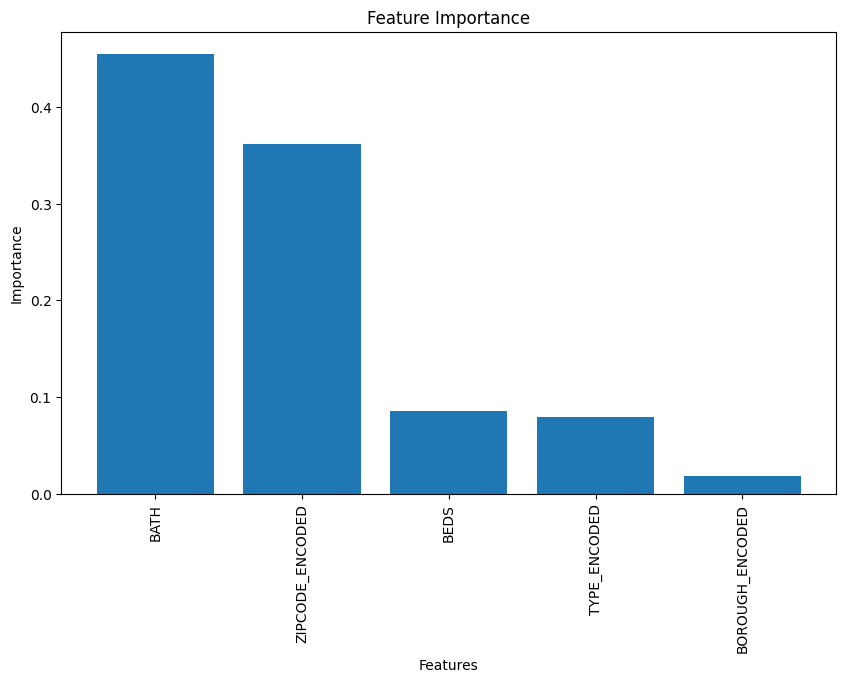

In [337]:
import matplotlib.pyplot as plt

# Get feature importances
importances = model.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]

# Get feature names
feature_names = X_train.columns[sorted_indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), sorted_importances, tick_label=feature_names)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()